In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from bayes_opt import BayesianOptimization
import category_encoders as ce
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
train = pd.read_csv(r'train.csv', index_col=0)
test = pd.read_csv(r'test.csv', index_col=0)

In [3]:
#metrica
def MAE(actual, pred):
    return (np.mean(np.absolute(actual - pred)))

## Preprocesamiento

In [4]:
train.isnull().sum()

titulo                          5387
descripcion                     1619
tipodepropiedad                   46
direccion                      53072
ciudad                           372
provincia                        155
antiguedad                     43555
habitaciones                   22471
garages                        37765
banos                          26221
metroscubiertos                17400
metrostotales                  51467
idzona                         28621
lat                           123488
lng                           123488
fecha                              0
gimnasio                           0
usosmultiples                      0
piscina                            0
escuelascercanas                   0
centroscomercialescercanos         0
precio                             0
dtype: int64

In [5]:
test.isnull().sum()

titulo                         1378
descripcion                     401
tipodepropiedad                   7
direccion                     13191
ciudad                           83
provincia                        42
antiguedad                    10714
habitaciones                   5628
garages                        9323
banos                          6554
metroscubiertos                4299
metrostotales                 12655
idzona                         7179
lat                           30695
lng                           30695
fecha                             0
gimnasio                          0
usosmultiples                     0
piscina                           0
escuelascercanas                  0
centroscomercialescercanos        0
dtype: int64

In [6]:
train['provincia'] = train['provincia'].fillna('Distrito Federal') #valor mas frecuente
test['provincia'] = test['provincia'].fillna('Distrito Federal')
train['tipodepropiedad'] = train['tipodepropiedad'].fillna('Casa') #valor mas frecuente
test['tipodepropiedad'] = test['tipodepropiedad'].fillna('Casa')

train['descripcion'] = train['descripcion'].fillna('-')
test['descripcion'] = test['descripcion'].fillna('-')

train = train.fillna(0)
test = test.fillna(0)

In [7]:
print(train.shape)
print(test.shape)

(240000, 22)
(60000, 21)


## Feature Engineering

### One Hot Encoding

In [8]:
one_hot_enc = ce.OneHotEncoder()
one_hot_encoded = one_hot_enc.fit_transform(train['provincia'])
train = train.join(one_hot_encoded)
del train['provincia']

one_hot_encoded = one_hot_enc.transform(test['provincia'])
test = test.join(one_hot_encoded)
del test['provincia']

In [9]:
one_hot_enc = ce.OneHotEncoder()
one_hot_encoded = one_hot_enc.fit_transform(train['tipodepropiedad'])
train = train.join(one_hot_encoded)
del train['tipodepropiedad']

one_hot_encoded = one_hot_enc.transform(test['tipodepropiedad'])
test = test.join(one_hot_encoded)
del test['tipodepropiedad']

### Target Encoding

In [10]:
print(train.shape)
print(test.shape)

(240000, 76)
(60000, 75)


In [11]:
X = train.drop('precio', axis = 1)
y = train['precio']
target_enc = ce.TargetEncoder(cols=['idzona', 'ciudad'])
train = target_enc.fit_transform(X, y)
train['precio'] = y

In [12]:
test = target_enc.transform(test)

In [13]:
print(train.shape)
print(test.shape)

(240000, 76)
(60000, 75)


### Agregando Features

#### Avenida

In [14]:
def avenida(st):
    return ("av." in st) or ("avenida" in st) or  ("av " in st)

In [15]:
test = test.astype({"direccion":"str"})
train = train.astype({"direccion":"str"})

test["direccion"] = test["direccion"].apply(str.lower)
test["avenida"] = test["direccion"].map(avenida)

train["direccion"] = train["direccion"].apply(str.lower)
train["avenida"] = train["direccion"].map(avenida)

test = test.astype({"avenida":"uint8"})
train = train.astype({"avenida":"uint8"})

#### Cantidad de amenities

In [16]:
train['cant_amenities'] = train['usosmultiples'] + train['piscina'] + train['gimnasio']
test['cant_amenities'] = test['usosmultiples'] + test['piscina'] + test['gimnasio']

#### Año de publicación

In [17]:
train['fecha'] = pd.to_datetime(train['fecha'])
train['ano'] = train['fecha'].dt.year

test['fecha'] = pd.to_datetime(test['fecha'])
test['ano'] = test['fecha'].dt.year

#### De la descripción

In [18]:
buena_ubicacion = ['buena ubicacion', 'buena ubicación', 'excelente ubicación', 'excelente ubicacion', 'bien ubicada', 'bien ubicado']
train['buena_ubicacion'] = train['descripcion'].apply(lambda x: 1 if any(word in x for word in buena_ubicacion ) else 0)
test['buena_ubicacion'] = test['descripcion'].apply(lambda x: 1 if any(word in x for word in buena_ubicacion ) else 0)

In [19]:
luminoso = ['luminoso', 'luminosa']
train['luminoso'] = train['descripcion'].apply(lambda x: 1 if any(word in x for word in luminoso ) else 0)
test['luminoso'] = test['descripcion'].apply(lambda x: 1 if any(word in x for word in luminoso ) else 0)

In [20]:
jardin = ['jardin', 'jardín', 'parque', 'patio']
train['jardin'] = train['descripcion'].apply(lambda x: 1 if any(word in x for word in luminoso ) else 0)
test['jardin'] = test['descripcion'].apply(lambda x: 1 if any(word in x for word in luminoso ) else 0)

In [21]:
balcon = ['balcon', 'balcón', 'terraza']
train['balcon'] = train['descripcion'].apply(lambda x: 1 if any(word in x for word in luminoso ) else 0)
test['balcon'] = test['descripcion'].apply(lambda x: 1 if any(word in x for word in luminoso ) else 0)

#### Cercanías

In [22]:
train['centroscomercialescercanos'] = train['centroscomercialescercanos'].map({1:2, 0:0})
test['centroscomercialescercanos'] = test['centroscomercialescercanos'].map({1:2, 0:0})

In [23]:
train['cercanias'] = train['centroscomercialescercanos'] + train['escuelascercanas']
train['cercanias'] = train['cercanias'].astype(str)

test['cercanias'] = test['centroscomercialescercanos'] + test['escuelascercanas']
test['cercanias'] = test['cercanias'].astype(str)

In [24]:
train = train.join(pd.get_dummies(train['cercanias'], prefix = 'cercania'))
del train['cercanias']

test = test.join(pd.get_dummies(test['cercanias'], prefix = 'cercania'))
del test['cercanias']

### Borrando columnas innecesarias

In [25]:
del train['lat']
del train['lng']
del train['descripcion']
del train['titulo']
del train['direccion']
del train['fecha']

del test['lat']
del test['lng']
del test['descripcion']
del test['titulo']
del test['direccion']
del test['fecha']

In [26]:
print(train.shape)
print(test.shape)

(240000, 81)
(60000, 80)


### Dividiendo por año

In [27]:
train_2012 = train[train['ano'] == 2012]
train_2013 = train[train['ano'] == 2013]
train_2014 = train[train['ano'] == 2014]
train_2015 = train[train['ano'] == 2015]
train_2016 = train[train['ano'] == 2016]

test_2012 = test[test['ano'] == 2012]
test_2013 = test[test['ano'] == 2013]
test_2014 = test[test['ano'] == 2014]
test_2015 = test[test['ano'] == 2015]
test_2016 = test[test['ano'] == 2016]

## Definiendo tamaños de los sets

In [28]:
def train_set(train,test):
    X = train.drop(['precio'], axis=1)
    y = train['precio']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1)
    print("Train shapes: X = " + str(X_train.shape) + " y = " + str(y_train.shape))
    print("Validation shapes: X = " + str(X_val.shape) +  " y = " + str(y_val.shape))
    print("Test shape: " + str(test.shape))
    return X, y, X_val, y_val

In [29]:
x_2012, y_2012, x_2012_val, y_2012_val = train_set(train_2012,test_2012)
x_2013, y_2013, x_2013_val, y_2013_val = train_set(train_2013,test_2013)
x_2014, y_2014, x_2014_val, y_2014_val = train_set(train_2014,test_2014)
x_2015, y_2015, x_2015_val, y_2015_val = train_set(train_2015,test_2015)
x_2016, y_2016, x_2016_val, y_2016_val = train_set(train_2016,test_2016)

Train shapes: X = (17650, 80) y = (17650,)
Validation shapes: X = (5884, 80) y = (5884,)
Test shape: (5899, 80)
Train shapes: X = (22789, 80) y = (22789,)
Validation shapes: X = (7597, 80) y = (7597,)
Test shape: (7592, 80)
Train shapes: X = (30429, 80) y = (30429,)
Validation shapes: X = (10143, 80) y = (10143,)
Test shape: (10018, 80)
Train shapes: X = (38602, 80) y = (38602,)
Validation shapes: X = (12868, 80) y = (12868,)
Test shape: (13017, 80)
Train shapes: X = (70528, 80) y = (70528,)
Validation shapes: X = (23510, 80) y = (23510,)
Test shape: (23474, 80)


## KNN

In [27]:
def KNN(train, param_grid):
    KNN = KNeighborsRegressor()
    X = train.drop(['precio'], axis=1)
    y = train['precio']
    grid = GridSearchCV(KNN, param_grid, cv=5, scoring='neg_mean_absolute_error')
    grid.fit(X, y)
    KNN = grid.best_estimator_
    print(grid.best_params_)
    print(grid.best_score_)
    return KNN

In [ ]:
k_valores = list(range(1, 21))
param_grid = dict(n_neighbors=k_valores)
KNN_2012 = KNN(x_2012, param_grid)
KNN_2013 = KNN(x_2013, param_grid)
KNN_2014 = KNN(x_2014, param_grid)
KNN_2015 = KNN(x_2015, param_grid)
KNN_2016 = KNN(x_2016, param_grid)

## LIGHTGBM

### Tuneo de hiperparámetros

In [38]:
import lightgbm
def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, min_split_gain, min_child_weight, learning_rate, seed,n_estimators):
    params = {}
    params['metric'] = 'rmse'
    params["seed"] = int(seed)
    params["learning_rate"] = learning_rate
    params["num_leaves"] = int(round(num_leaves))
    params['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
    params['max_depth'] = int(round(max_depth))
    params['min_split_gain'] = min_split_gain
    params['min_child_weight'] = min_child_weight
    params["n_estimators"] = int(n_estimators)
    cv_result = lightgbm.cv(params, dtrain, nfold=5, num_boost_round=100)
    # Used around 1000 boosting rounds in the full model
    #cv_result = lightgbm.cv(params, dtrain, num_boost_round=100, nfold=3, seed=20)    
    
    # Bayesian optimization only knows how to maximize, not minimize, so return the negative RMSE
    return max(cv_result['rmse-mean'])

In [39]:
def optimize_lgbm(sett):
    dtrain = sett
    lightgbm_bo = BayesianOptimization(lgb_eval, {'num_leaves': (24, 45),
                                        'feature_fraction': (0.1, 0.9),
                                        'bagging_fraction': (0.8, 1),
                                        'max_depth': (5, 8.99),
                                        'min_split_gain': (0.001, 0.1),
                                        'min_child_weight': (5, 50),
                                        "learning_rate" : (0.01, 0.07),
                                        "seed":(10,50),
                                        "n_estimators":(100,1000)          
                                        }, random_state=0)
    # Se probo con 3 puntos iniciales y 10 iteraciones, deberiamos probar con mas en ambas
    # La prox iteracion en casa probar 100 y 10000
    lightgbm_bo.maximize(init_points=3, n_iter=10, acq='ei')
    params = lightgbm_bo.max['params']
    params['max_depth'] = int(params['max_depth'])
    params["seed"] = int(params["seed"])
    params["n_estimators"] = int(params["n_estimators"])
    return params

In [40]:
feature_set = list(x_2012.columns)
dtrain_2012 = lightgbm.Dataset(x_2012, label=y_2012,feature_name=feature_set)
feature_set = list(x_2013.columns)
dtrain_2013 = lightgbm.Dataset(x_2013, label=y_2013,feature_name=feature_set)
feature_set = list(x_2014.columns)
dtrain_2014 = lightgbm.Dataset(x_2014, label=y_2014,feature_name=feature_set)
feature_set = list(x_2015.columns)
dtrain_2015 = lightgbm.Dataset(x_2015, label=y_2015,feature_name=feature_set)
feature_set = list(x_2016.columns)
dtrain_2016 = lightgbm.Dataset(x_2016, label=y_2016,feature_name=feature_set)


In [41]:
dtrain = dtrain_2012
params_2012 = optimize_lgbm(dtrain_2012)
dtrain = dtrain_2013
params_2013 = optimize_lgbm(dtrain_2013)
dtrain = dtrain_2014
params_2014 = optimize_lgbm(dtrain_2014)
dtrain = dtrain_2015
params_2015 = optimize_lgbm(dtrain_2015)
dtrain = dtrain_2016
params_2016 = optimize_lgbm(dtrain_2016)

|   iter    |  target   | baggin... | featur... | learni... | max_depth | min_ch... | min_sp... | n_esti... | num_le... |   seed    |
-------------------------------------------------------------------------------------------------------------------------------------


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  1        |  1.727e+0 |  0.9098   |  0.6722   |  0.04617  |  7.174    |  24.06    |  0.06494  |  493.8    |  42.73    |  48.55    |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  2        |  1.739e+0 |  0.8767   |  0.7334   |  0.04173  |  7.266    |  46.65    |  0.008033 |  178.4    |  24.42    |  43.3     |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  3        |  1.702e+0 |  0.9556   |  0.796    |  0.06872  |  8.189    |  25.77    |  0.07827  |  206.4    |  37.44    |  15.73    |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  4        |  1.772e+0 |  0.8844   |  0.2402   |  0.01921  |  8.225    |  9.211    |  0.001068 |  749.3    |  30.28    |  39.33    |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  5        |  1.761e+0 |  0.8595   |  0.843    |  0.01736  |  5.968    |  23.52    |  0.03308  |  615.2    |  28.82    |  47.88    |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  6        |  1.755e+0 |  0.9116   |  0.6652   |  0.0291   |  6.534    |  18.14    |  0.06617  |  609.8    |  29.32    |  45.58    |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  7        |  1.711e+0 |  0.9396   |  0.2106   |  0.06445  |  7.494    |  34.7     |  0.06542  |  662.8    |  28.8     |  36.39    |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  8        |  1.722e+0 |  0.9603   |  0.865    |  0.05059  |  6.625    |  21.06    |  0.02608  |  141.6    |  36.43    |  18.61    |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  9        |  1.713e+0 |  0.9577   |  0.6611   |  0.05888  |  7.25     |  41.3     |  0.07923  |  836.8    |  32.23    |  37.26    |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  10       |  1.758e+0 |  0.8575   |  0.2975   |  0.03868  |  5.398    |  40.28    |  0.09882  |  179.3    |  25.36    |  38.65    |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  11       |  1.759e+0 |  0.951    |  0.6561   |  0.02132  |  8.973    |  41.21    |  0.04594  |  289.4    |  26.45    |  28.42    |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  12       |  1.766e+0 |  0.8457   |  0.4622   |  0.01581  |  6.111    |  28.36    |  0.05396  |  754.0    |  38.65    |  44.3     |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  13       |  1.73e+06 |  0.853    |  0.4545   |  0.0522   |  5.427    |  38.43    |  0.001316 |  103.9    |  33.05    |  13.05    |
|   iter    |  target   | baggin... | featur... | learni... | max_depth | min_ch... | min_sp... | n_esti... | num_le... |   seed    |
-------------------------------------------------------------------------------------------------------------------------------------


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  1        |  1.787e+0 |  0.9098   |  0.6722   |  0.04617  |  7.174    |  24.06    |  0.06494  |  493.8    |  42.73    |  48.55    |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  2        |  1.801e+0 |  0.8767   |  0.7334   |  0.04173  |  7.266    |  46.65    |  0.008033 |  178.4    |  24.42    |  43.3     |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  3        |  1.76e+06 |  0.9556   |  0.796    |  0.06872  |  8.189    |  25.77    |  0.07827  |  206.4    |  37.44    |  15.73    |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  4        |  1.839e+0 |  0.8844   |  0.2402   |  0.01921  |  8.225    |  9.211    |  0.001068 |  749.3    |  30.28    |  39.33    |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  5        |  1.826e+0 |  0.8595   |  0.843    |  0.01736  |  5.968    |  23.52    |  0.03308  |  615.2    |  28.82    |  47.88    |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  6        |  1.819e+0 |  0.9116   |  0.6652   |  0.0291   |  6.534    |  18.14    |  0.06617  |  609.8    |  29.32    |  45.58    |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  7        |  1.768e+0 |  0.9396   |  0.2106   |  0.06445  |  7.494    |  34.7     |  0.06542  |  662.8    |  28.8     |  36.39    |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  8        |  1.783e+0 |  0.9603   |  0.865    |  0.05059  |  6.625    |  21.06    |  0.02608  |  141.6    |  36.43    |  18.61    |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  9        |  1.774e+0 |  0.9577   |  0.6611   |  0.05888  |  7.25     |  41.3     |  0.07923  |  836.8    |  32.23    |  37.26    |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  10       |  1.826e+0 |  0.8575   |  0.2975   |  0.03868  |  5.398    |  40.28    |  0.09882  |  179.3    |  25.36    |  38.65    |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  11       |  1.823e+0 |  0.951    |  0.6561   |  0.02132  |  8.973    |  41.21    |  0.04594  |  289.4    |  26.45    |  28.42    |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  12       |  1.83e+06 |  0.8457   |  0.4622   |  0.01581  |  6.111    |  28.36    |  0.05396  |  754.0    |  38.65    |  44.3     |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  13       |  1.791e+0 |  0.853    |  0.4545   |  0.0522   |  5.427    |  38.43    |  0.001316 |  103.9    |  33.05    |  13.05    |
|   iter    |  target   | baggin... | featur... | learni... | max_depth | min_ch... | min_sp... | n_esti... | num_le... |   seed    |
-------------------------------------------------------------------------------------------------------------------------------------


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  1        |  1.921e+0 |  0.9098   |  0.6722   |  0.04617  |  7.174    |  24.06    |  0.06494  |  493.8    |  42.73    |  48.55    |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  2        |  1.934e+0 |  0.8767   |  0.7334   |  0.04173  |  7.266    |  46.65    |  0.008033 |  178.4    |  24.42    |  43.3     |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  3        |  1.893e+0 |  0.9556   |  0.796    |  0.06872  |  8.189    |  25.77    |  0.07827  |  206.4    |  37.44    |  15.73    |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  4        |  1.98e+06 |  0.8844   |  0.2402   |  0.01921  |  8.225    |  9.211    |  0.001068 |  749.3    |  30.28    |  39.33    |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  5        |  1.959e+0 |  0.8595   |  0.843    |  0.01736  |  5.968    |  23.52    |  0.03308  |  615.2    |  28.82    |  47.88    |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  6        |  1.953e+0 |  0.9116   |  0.6652   |  0.0291   |  6.534    |  18.14    |  0.06617  |  609.8    |  29.32    |  45.58    |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  7        |  1.913e+0 |  0.9396   |  0.2106   |  0.06445  |  7.494    |  34.7     |  0.06542  |  662.8    |  28.8     |  36.39    |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  8        |  1.916e+0 |  0.9603   |  0.865    |  0.05059  |  6.625    |  21.06    |  0.02608  |  141.6    |  36.43    |  18.61    |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  9        |  1.907e+0 |  0.9577   |  0.6611   |  0.05888  |  7.25     |  41.3     |  0.07923  |  836.8    |  32.23    |  37.26    |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  10       |  1.956e+0 |  0.8575   |  0.2975   |  0.03868  |  5.398    |  40.28    |  0.09882  |  179.3    |  25.36    |  38.65    |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  11       |  1.956e+0 |  0.951    |  0.6561   |  0.02132  |  8.973    |  41.21    |  0.04594  |  289.4    |  26.45    |  28.42    |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  12       |  1.963e+0 |  0.8457   |  0.4622   |  0.01581  |  6.111    |  28.36    |  0.05396  |  754.0    |  38.65    |  44.3     |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  13       |  1.921e+0 |  0.853    |  0.4545   |  0.0522   |  5.427    |  38.43    |  0.001316 |  103.9    |  33.05    |  13.05    |
|   iter    |  target   | baggin... | featur... | learni... | max_depth | min_ch... | min_sp... | n_esti... | num_le... |   seed    |
-------------------------------------------------------------------------------------------------------------------------------------


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  1        |  2.121e+0 |  0.9098   |  0.6722   |  0.04617  |  7.174    |  24.06    |  0.06494  |  493.8    |  42.73    |  48.55    |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  2        |  2.134e+0 |  0.8767   |  0.7334   |  0.04173  |  7.266    |  46.65    |  0.008033 |  178.4    |  24.42    |  43.3     |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  3        |  2.089e+0 |  0.9556   |  0.796    |  0.06872  |  8.189    |  25.77    |  0.07827  |  206.4    |  37.44    |  15.73    |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  4        |  2.166e+0 |  0.8844   |  0.2402   |  0.01921  |  8.225    |  9.211    |  0.001068 |  749.3    |  30.28    |  39.33    |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  5        |  2.164e+0 |  0.8595   |  0.843    |  0.01736  |  5.968    |  23.52    |  0.03308  |  615.2    |  28.82    |  47.88    |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  6        |  2.154e+0 |  0.9116   |  0.6652   |  0.0291   |  6.534    |  18.14    |  0.06617  |  609.8    |  29.32    |  45.58    |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  7        |  2.146e+0 |  0.9396   |  0.2106   |  0.06445  |  7.494    |  34.7     |  0.06542  |  662.8    |  28.8     |  36.39    |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  8        |  2.116e+0 |  0.9603   |  0.865    |  0.05059  |  6.625    |  21.06    |  0.02608  |  141.6    |  36.43    |  18.61    |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  9        |  2.105e+0 |  0.9577   |  0.6611   |  0.05888  |  7.25     |  41.3     |  0.07923  |  836.8    |  32.23    |  37.26    |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  10       |  2.162e+0 |  0.8575   |  0.2975   |  0.03868  |  5.398    |  40.28    |  0.09882  |  179.3    |  25.36    |  38.65    |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  11       |  2.16e+06 |  0.951    |  0.6561   |  0.02132  |  8.973    |  41.21    |  0.04594  |  289.4    |  26.45    |  28.42    |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  12       |  2.168e+0 |  0.8457   |  0.4622   |  0.01581  |  6.111    |  28.36    |  0.05396  |  754.0    |  38.65    |  44.3     |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  13       |  2.122e+0 |  0.853    |  0.4545   |  0.0522   |  5.427    |  38.43    |  0.001316 |  103.9    |  33.05    |  13.05    |
|   iter    |  target   | baggin... | featur... | learni... | max_depth | min_ch... | min_sp... | n_esti... | num_le... |   seed    |
-------------------------------------------------------------------------------------------------------------------------------------


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  1        |  2.254e+0 |  0.9098   |  0.6722   |  0.04617  |  7.174    |  24.06    |  0.06494  |  493.8    |  42.73    |  48.55    |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  2        |  2.267e+0 |  0.8767   |  0.7334   |  0.04173  |  7.266    |  46.65    |  0.008033 |  178.4    |  24.42    |  43.3     |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  3        |  2.22e+06 |  0.9556   |  0.796    |  0.06872  |  8.189    |  25.77    |  0.07827  |  206.4    |  37.44    |  15.73    |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  4        |  2.313e+0 |  0.8844   |  0.2402   |  0.01921  |  8.225    |  9.211    |  0.001068 |  749.3    |  30.28    |  39.33    |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  5        |  2.299e+0 |  0.8595   |  0.843    |  0.01736  |  5.968    |  23.52    |  0.03308  |  615.2    |  28.82    |  47.88    |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  6        |  2.291e+0 |  0.9116   |  0.6652   |  0.0291   |  6.534    |  18.14    |  0.06617  |  609.8    |  29.32    |  45.58    |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  7        |  2.259e+0 |  0.9396   |  0.2106   |  0.06445  |  7.494    |  34.7     |  0.06542  |  662.8    |  28.8     |  36.39    |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  8        |  2.248e+0 |  0.9603   |  0.865    |  0.05059  |  6.625    |  21.06    |  0.02608  |  141.6    |  36.43    |  18.61    |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  9        |  2.237e+0 |  0.9577   |  0.6611   |  0.05888  |  7.25     |  41.3     |  0.07923  |  836.8    |  32.23    |  37.26    |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  10       |  2.297e+0 |  0.8575   |  0.2975   |  0.03868  |  5.398    |  40.28    |  0.09882  |  179.3    |  25.36    |  38.65    |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  11       |  2.295e+0 |  0.951    |  0.6561   |  0.02132  |  8.973    |  41.21    |  0.04594  |  289.4    |  26.45    |  28.42    |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  12       |  2.303e+0 |  0.8457   |  0.4622   |  0.01581  |  6.111    |  28.36    |  0.05396  |  754.0    |  38.65    |  44.3     |


/home/lautaro/.local/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/lautaro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  13       |  2.253e+0 |  0.853    |  0.4545   |  0.0522   |  5.427    |  38.43    |  0.001316 |  103.9    |  33.05    |  13.05    |


In [47]:
print(params_2015)

{'bagging_fraction': 0.8456530825090609, 'feature_fraction': 0.4622280183459735, 'learning_rate': 0.01580539093297958, 'max_depth': 6, 'min_child_weight': 28.361441126886234, 'min_split_gain': 0.05396292555909297, 'n_estimators': 754, 'num_leaves': 38.6539753385936, 'seed': 44}


### Entrenando los modelos

In [48]:
from lightgbm import LGBMRegressor as lgbm
def fabrica_lgbm(params):
    best_lgbm_model = lgbm(#colsample_bytree=params["colsample_bytree"],
                 bagging_fracion=params["bagging_fraction"],
                 num_leaves=int(params["num_leaves"]),                 
                 learning_rate=params["learning_rate"],
                 max_depth=params["max_depth"],
                 min_child_weight=params["min_child_weight"],
                 n_estimators=params["n_estimators"],                                                                    
                 #reg_alpha=params["reg_alpha"],
                 #reg_lambda=params["reg_lambda"],
                 #subsample=params["subsample"],
                 seed=params["seed"])
    
    return best_lgbm_model

In [49]:
lgbm_2012 = fabrica_lgbm(params_2012)
lgbm_2013 = fabrica_lgbm(params_2013)
lgbm_2014 = fabrica_lgbm(params_2014)
lgbm_2015 = fabrica_lgbm(params_2015)
lgbm_2016 = fabrica_lgbm(params_2016)

In [50]:
lgbm_2012.fit(x_2012,y_2012)
lgbm_pred_val = lgbm_2012.predict(x_2012_val)
lgbm_mae = MAE(y_2012_val, lgbm_pred_val)
print("MAE LGBM: " + str(lgbm_mae))

MAE LGBM: 406024.91973549256


In [51]:
lgbm_2013.fit(x_2013,y_2013)
lgbm_pred_val = lgbm_2013.predict(x_2013_val)
lgbm_mae = MAE(y_2013_val, lgbm_pred_val)
print("MAE LGBM: " + str(lgbm_mae))

MAE LGBM: 407606.33905984863


In [52]:
lgbm_2014.fit(x_2014,y_2014)
lgbm_pred_val = lgbm_2014.predict(x_2014_val)
lgbm_mae = MAE(y_2014_val, lgbm_pred_val)
print("MAE LGBM: " + str(lgbm_mae))

MAE LGBM: 482616.50925858127


In [53]:
lgbm_2015.fit(x_2015,y_2015)
lgbm_pred_val = lgbm_2015.predict(x_2015_val)
lgbm_mae = MAE(y_2015_val, lgbm_pred_val)
print("MAE LGBM: " + str(lgbm_mae))

MAE LGBM: 534111.9699979337


In [54]:
lgbm_2016.fit(x_2016,y_2016)
lgbm_pred_val = lgbm_2016.predict(x_2016_val)
lgbm_mae = MAE(y_2016_val, lgbm_pred_val)
print("MAE LGBM: " + str(lgbm_mae))

MAE LGBM: 595856.9186336667


In [44]:
res_2012 = lgbm_2012.predict(test_2012)
res_2013 = lgbm_2013.predict(test_2013)
res_2014 = lgbm_2014.predict(test_2014)
res_2015 = lgbm_2015.predict(test_2015)
res_2016 = lgbm_2016.predict(test_2016)

### Feature Importance

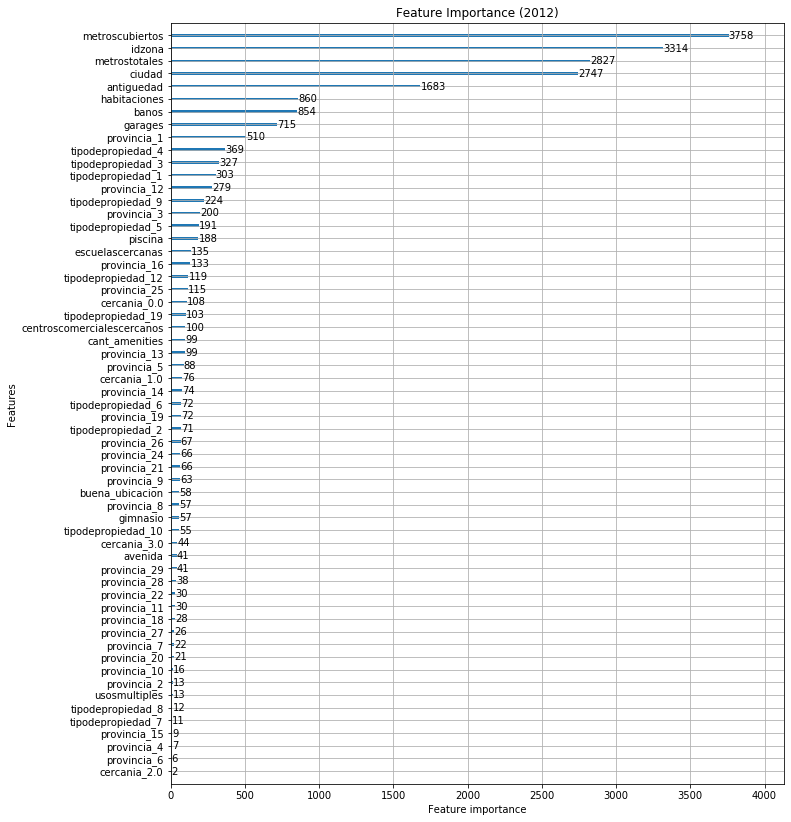

In [59]:
lightgbm.plot_importance(lgbm_2012, figsize=(11,14), title='Feature Importance (2012)');

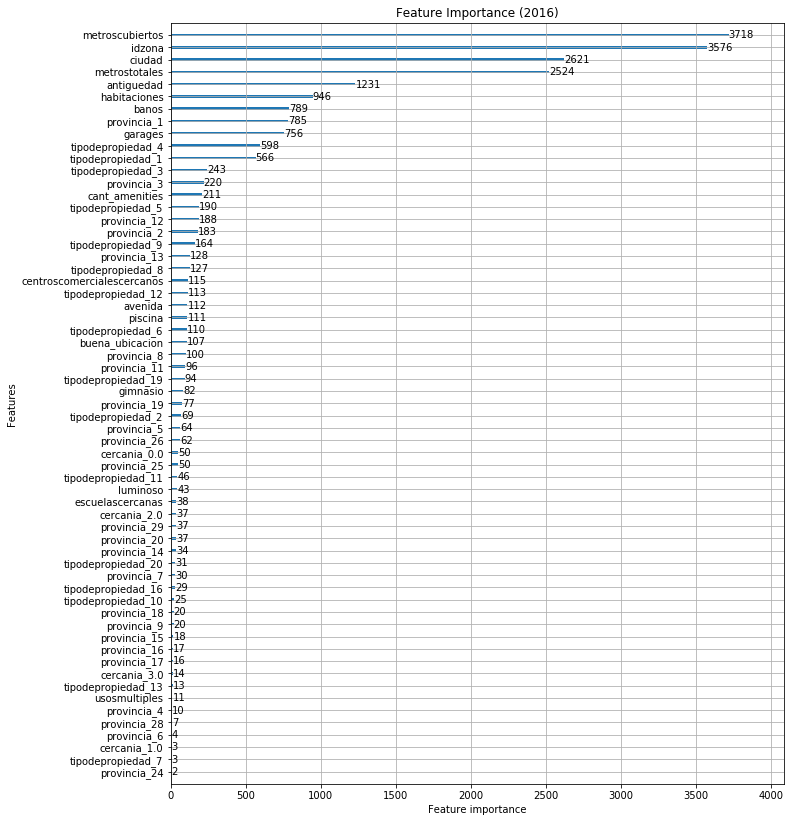

In [60]:
lightgbm.plot_importance(lgbm_2016, figsize=(11,14), title='Feature Importance (2016)');

## XGBoost

### Tuneo de hiperparámetros

In [61]:
import xgboost as xgb

dtrain_2012 = xgb.DMatrix(x_2012, label=y_2012)
dtrain_2013 = xgb.DMatrix(x_2013, label=y_2013)
dtrain_2014 = xgb.DMatrix(x_2014, label=y_2014)
dtrain_2015 = xgb.DMatrix(x_2015, label=y_2015)
dtrain_2016 = xgb.DMatrix(x_2016, label=y_2016)

/home/lautaro/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/lautaro/.local/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [62]:
def xgb_evaluate(max_depth, gamma, colsample_bytree,seed,min_child_weight,n_estimators,
                  reg_alpha,reg_lambda,subsample,learning_rate):
    params = {'eval_metric': 'rmse',
              'max_depth': int(max_depth),
              'subsample': subsample,
              'eta': 0.1,
              'gamma': gamma,
              'colsample_bytree': colsample_bytree,
              "seed": int(seed),
              "min_child_weight": min_child_weight,
              "n_estimators": n_estimators,
              "reg_alpha": reg_alpha,
              "reg_lambda": reg_lambda,
              "learning_rate": learning_rate
             }
    # Used around 1000 boosting rounds in the full model
    cv_result = xgb.cv(params, dtrain, num_boost_round=100, nfold=3)    
    
    # Bayesian optimization only knows how to maximize, not minimize, so return the negative RMSE
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

In [63]:
def optimize(sett):
    dtrain = sett
    xgb_bo = BayesianOptimization(xgb_evaluate, {'max_depth': (3, 7), 
                                             'gamma': (0, 1),
                                             'colsample_bytree': (0.3, 0.9),
                                             "seed": (10,50),
                                             "min_child_weight": (0.4,1.5),
                                             "n_estimators":(100,10000),                                                                    
                                             "reg_alpha":(0.2,0.75),
                                             "reg_lambda": (0.2,0.8),
                                             "subsample" : (0.3, 0.8),
                                             "learning_rate": (0.01,0.07),
                                            })
    # Se probo con 3 puntos iniciales y 10 iteraciones, deberiamos probar con mas en ambas
    # La prox iteracion en casa probar 100 y 10000
    xgb_bo.maximize(init_points=3, n_iter=10, acq='ei')
    params = xgb_bo.max['params']
    params['max_depth'] = int(params['max_depth'])
    params["seed"] = int(params["seed"])
    params["n_estimators"] = int(params["n_estimators"])
    return params

In [64]:
dtrain = dtrain_2012
params_2012 = optimize(dtrain_2012)
dtrain = dtrain_2013
params_2013 = optimize(dtrain_2013)
dtrain = dtrain_2014
params_2014 = optimize(dtrain_2014)
dtrain = dtrain_2015
params_2015 = optimize(dtrain_2015)
dtrain = dtrain_2016
params_2016 = optimize(dtrain_2016)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... |   seed    | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -9.253e+0 |  0.3988   |  0.6329   |  0.04436  |  4.332    |  0.5284   |  2.014e+0 |  0.4796   |  0.5848   |  12.2     |  0.5697   |
|  2        | -1.116e+0 |  0.7031   |  0.5461   |  0.0166   |  4.006    |  1.087    |  8.764e+0 |  0.4121   |  0.7523   |  26.35    |  0.657    |
|  3        | -1.277e+0 |  0.8382   |  0.3709   |  0.01367  |  3.113    |  0.835    |  3.826e+0 |  0.646    |  0.2289   |  20.82    |  0.5337   |
|  4        | -9.66e+05 |  0.5004   |  0.8534   |  0.041    |  3.044    |  1.037    |  2.135e+0 |  0.4713   |  0.2046   |  16.62    |  0.3578   |
|  5        | -9.745e+0 |  0.3091   |  0.5412   |  0.02828  |  5.854    |  0.495    |  8.654e+0 |  0.4426   |  0.2519   |  2

|  4        | -1.201e+0 |  0.5396   |  0.4717   |  0.0169   |  5.357    |  1.479    |  253.3    |  0.3572   |  0.7402   |  23.03    |  0.4623   |
|  5        | -1.438e+0 |  0.7351   |  0.2754   |  0.01105  |  6.417    |  1.1      |  2.338e+0 |  0.5866   |  0.6147   |  23.43    |  0.3256   |
|  6        | -9.332e+0 |  0.8191   |  0.1375   |  0.06961  |  5.919    |  0.759    |  766.5    |  0.2059   |  0.5052   |  23.5     |  0.5211   |
|  7        | -9.749e+0 |  0.4531   |  0.1345   |  0.06647  |  4.629    |  1.477    |  1.422e+0 |  0.5036   |  0.4184   |  17.51    |  0.6724   |
|  8        | -1.099e+0 |  0.591    |  0.01524  |  0.03177  |  3.388    |  1.37     |  8.053e+0 |  0.5177   |  0.769    |  48.92    |  0.6008   |
|  9        | -1.04e+06 |  0.3599   |  0.01765  |  0.05737  |  3.672    |  1.133    |  5.271e+0 |  0.7257   |  0.5698   |  40.28    |  0.3828   |
|  10       | -1.07e+06 |  0.5584   |  0.03849  |  0.03856  |  3.58     |  1.472    |  1.936e+0 |  0.6942   |  0.637    |  4

|  8        | -1.091e+0 |  0.7082   |  0.6747   |  0.03291  |  6.718    |  0.5845   |  8.253e+0 |  0.5954   |  0.6507   |  47.02    |  0.4009   |
|  9        | -1.123e+0 |  0.404    |  0.9987   |  0.03798  |  5.625    |  1.258    |  4.098e+0 |  0.2752   |  0.3128   |  38.36    |  0.5019   |
|  10       | -1.44e+06 |  0.3663   |  0.07369  |  0.02124  |  3.513    |  1.19     |  8.255e+0 |  0.5256   |  0.3303   |  44.24    |  0.5946   |
|  11       | -1.186e+0 |  0.7964   |  0.7931   |  0.05171  |  3.447    |  0.8404   |  4.174e+0 |  0.6944   |  0.629    |  47.55    |  0.7211   |
|  12       | -1.099e+0 |  0.8788   |  0.6897   |  0.04097  |  5.145    |  0.4904   |  3.425e+0 |  0.5853   |  0.4691   |  29.33    |  0.3175   |
|  13       | -1.918e+0 |  0.3805   |  0.4826   |  0.0107   |  3.843    |  0.9523   |  4.611e+0 |  0.3891   |  0.5447   |  26.93    |  0.7698   |


### Entrenando los modelos

In [65]:
def fabrica_XGB(params):
    best_xgb_model = XGBRegressor(colsample_bytree=params["colsample_bytree"],
                 gamma=params["gamma"],                 
                 learning_rate=params["learning_rate"],
                 max_depth=params["max_depth"],
                 min_child_weight=params["min_child_weight"],
                 n_estimators=params["n_estimators"],                                                                    
                 reg_alpha=params["reg_alpha"],
                 reg_lambda=params["reg_lambda"],
                 subsample=params["subsample"],
                 seed=params["seed"])
    
    return best_xgb_model

In [66]:
XGB_2012 = fabrica_XGB(params_2012)
XGB_2013 = fabrica_XGB(params_2013)
XGB_2014 = fabrica_XGB(params_2014)
XGB_2015 = fabrica_XGB(params_2015)
XGB_2016 = fabrica_XGB(params_2016)

In [67]:
XGB_2012.fit(x_2012,y_2012)
XGB_pred_val = XGB_2012.predict(x_2012_val)
XGB_mae = MAE(y_2012_val, XGB_pred_val)
print("MAE XGB: " + str(XGB_mae))

/home/lautaro/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/lautaro/.local/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[18:42:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE XGB: 70108.38328783566


In [ ]:
XGB_2013.fit(x_2013,y_2013)
XGB_pred_val = XGB_2013.predict(x_2013_val)
XGB_mae = MAE(y_2013_val, XGB_pred_val)
print("MAE XGB: " + str(XGB_mae))

In [ ]:
XGB_2014.fit(x_2014,y_2014)
XGB_pred_val = XGB_2014.predict(x_2014_val)
XGB_mae = MAE(y_2014_val, XGB_pred_val)
print("MAE XGB: " + str(XGB_mae))

In [ ]:
XGB_2015.fit(x_2015,y_2015)
XGB_pred_val = XGB_2015.predict(x_2015_val)
XGB_mae = MAE(y_2015_val, XGB_pred_val)
print("MAE XGB: " + str(XGB_mae))

In [ ]:
XGB_2016.fit(x_2016,y_2016)
XGB_pred_val = XGB_2016.predict(x_2016_val)
XGB_mae = MAE(y_2016_val, XGB_pred_val)
print("MAE XGB: " + str(XGB_mae))

## Random Forest

### Feature Importance

In [30]:
X = train.drop(['precio'], axis=1)
y = train['precio']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1)

In [32]:
rf_features = RandomForestRegressor(random_state=42)
rf_features.fit(X_train, y_train)

/home/lautaro/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [33]:
feature_list = list(X_train.columns)
importances = list(rf_features.feature_importances_)
feature_importances = [(feature, importance) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: idzona               Importance: 0.47329565718895966
Variable: metroscubiertos      Importance: 0.21009621733652883
Variable: metrostotales        Importance: 0.059899188455267684
Variable: ciudad               Importance: 0.05227174487540433
Variable: antiguedad           Importance: 0.02678074777460749
Variable: ano                  Importance: 0.026449945105023902
Variable: banos                Importance: 0.018199514152946857
Variable: habitaciones         Importance: 0.014957642782856356
Variable: tipodepropiedad_4    Importance: 0.013665069360578269
Variable: provincia_1          Importance: 0.013274686238192734
Variable: tipodepropiedad_1    Importance: 0.010896991570626104
Variable: garages              Importance: 0.0108246946056091
Variable: tipodepropiedad_9    Importance: 0.006819235961923398
Variable: tipodepropiedad_3    Importance: 0.00584819093612393
Variable: provincia_3          Importance: 0.004032075774866648
Variable: tipodepropiedad_5    Importance: 0.00

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

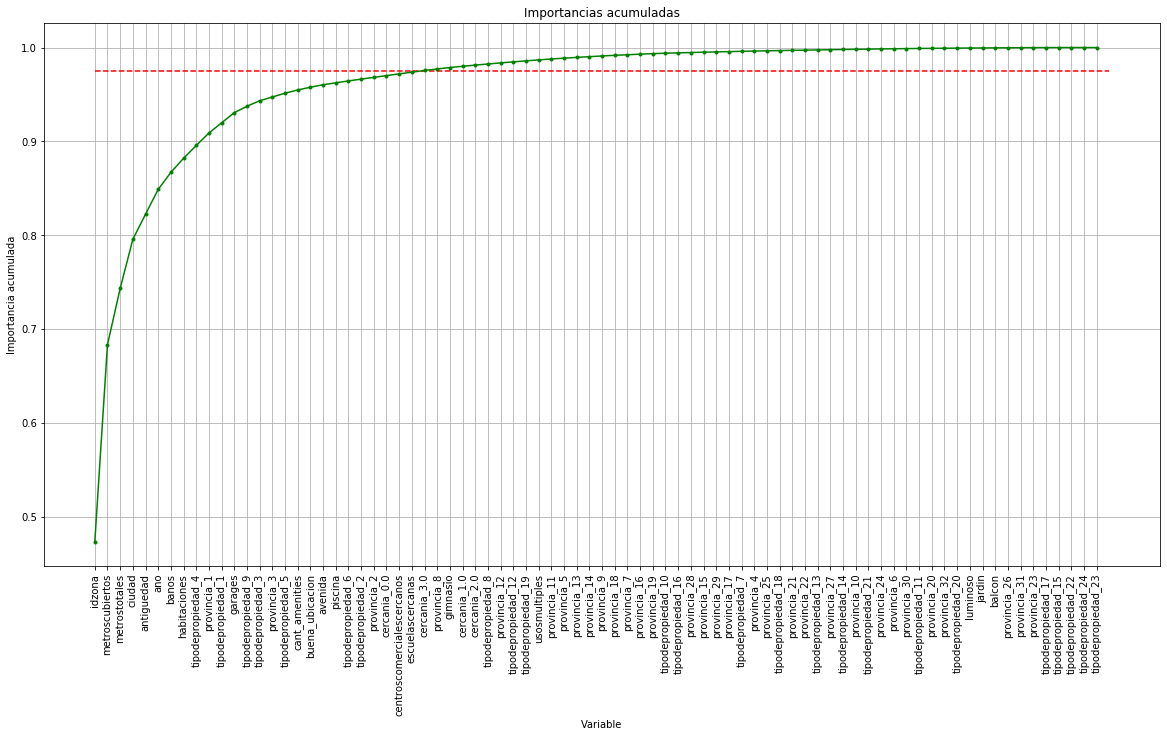

In [34]:
x_values = list(range(len(importances)))
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
cumulative_importances = np.cumsum(sorted_importances)
plt.figure(figsize=(20,10)) 
plt.plot(x_values, cumulative_importances, 'g.-')
plt.grid(True)
plt.hlines(y = 0.975, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
plt.xticks(x_values, sorted_features, rotation = 'vertical')
plt.xlabel('Variable'); plt.ylabel('Importancia acumulada'); plt.title('Importancias acumuladas');

### Entrenando los modelos

In [30]:
def fabrica_RF(train, param_grid):
    X = train.drop(['precio'], axis=1)
    y = train['precio']
    RF = RandomForestRegressor(random_state=42)
    grid = GridSearchCV(RF, param_grid, cv=4, scoring='neg_mean_absolute_error')
    grid.fit(train, train_y)
    RF = grid.best_estimator_
    print(grid.best_params_)
    print(grid.best_score_)
    return RF

In [31]:
param_grid = {
    'n_estimators': [100, 200, 300]
}

In [70]:
rf_2012 = fabrica_RF(train_2012, param_grid)

KeyError: "['precio'] not found in axis"

In [51]:
rf_2013 = fabrica_RF(train_2013, param_grid)

{'n_estimators': 300}
-454293.34004936565


In [45]:
rf_2014 = fabrica_RF(train_2014, param_grid)

{'n_estimators': 300}
-517081.3317439341


In [46]:
rf_2015 = fabrica_RF(train_2015, param_grid)

{'n_estimators': 300}
-546887.6856364366


In [44]:
rf_2016 = fabrica_RF(train_2016, param_grid)

{'n_estimators': 300}
-581579.9190220906


In [52]:
res_2012 = rf_2012.predict(test_2012)
res_2013 = rf_2013.predict(test_2013)
res_2014 = rf_2014.predict(test_2014)
res_2015 = rf_2015.predict(test_2015)
res_2016 = rf_2016.predict(test_2016)

## Ensembles

In [ ]:
ensemble2012 = VotingRegressor([('rf', rf_2012), ('xgb', XGB_2012),('lgbm', lgbm_2012)])
ensemble2013 = VotingRegressor([('rf', rf_2013), ('xgb', XGB_2013),('lgbm', lgbm_2013)])
ensemble2014 = VotingRegressor([('rf', rf_2014), ('xgb', XGB_2014),('lgbm', lgbm_2014)])
ensemble2015 = VotingRegressor([('rf', rf_2015), ('xgb', XGB_2015),('lgbm', lgbm_2015)])
ensemble2016 = VotingRegressor([('rf', rf_2016), ('xgb', XGB_2016),('lgbm', lgbm_2016)])

In [56]:
ensemble2012.fit(x_2012, y_2012)
en_pred_val = ensemble2012.predict(x_2012_val)
en_mae = MAE(y_2012_val, en_pred_val)
print("MAE Ensemble: " + str(en_mae))

MAE Ensemble: 281267.91291405365


In [58]:
ensemble2013.fit(x_2013, y_2013)
en_pred_val = ensemble2013.predict(x_2013_val)
en_mae = MAE(y_2013_val, en_pred_val)
print("MAE Ensemble: " + str(en_mae))

MAE Ensemble: 279493.94242746645


In [59]:
ensemble2014.fit(x_2014, y_2014)
en_pred_val = ensemble2014.predict(x_2014_val)
en_mae = MAE(y_2014_val, en_pred_val)
print("MAE Ensemble: " + str(en_mae))

MAE Ensemble: 327185.51345922425


In [60]:
ensemble2015.fit(x_2015, y_2015)
en_pred_val = ensemble2015.predict(x_2015_val)
en_mae = MAE(y_2015_val, en_pred_val)
print("MAE Ensemble: " + str(en_mae))

MAE Ensemble: 357962.1142812169


In [ ]:
ensemble2016.fit(x_2016, y_2016)
en_pred_val = ensemble2016.predict(x_2016_val)
en_mae = MAE(y_2016_val, en_pred_val)
print("MAE Ensemble: " + str(en_mae))

In [41]:
res_2012 = ensemble2012.predict(test_2012)
res_2013 = ensemble2013.predict(test_2013)
res_2014 = ensemble2014.predict(test_2014)
res_2015 = ensemble2015.predict(test_2015)
res_2016 = ensemble2016.predict(test_2016)

In [45]:
res_2012 = pd.DataFrame(res_2012, index=test_2012.index, columns=['precio'])
res_2012 = res_2012.rename(columns={'precio':'target'})

res_2013 = pd.DataFrame(res_2013, index=test_2013.index, columns=['precio'])
res_2013 = res_2013.rename(columns={'precio':'target'})

res_2014 = pd.DataFrame(res_2014, index=test_2014.index, columns=['precio'])
res_2014 = res_2014.rename(columns={'precio':'target'})

res_2015 = pd.DataFrame(res_2015, index=test_2015.index, columns=['precio'])
res_2015 = res_2015.rename(columns={'precio':'target'})

res_2016 = pd.DataFrame(res_2016, index=test_2016.index, columns=['precio'])
res_2016 = res_2016.rename(columns={'precio':'target'})

In [47]:
res = res_2012.append(res_2013).append(res_2014).append(res_2015).append(res_2016)
res.to_csv("workshop-submission-lgbm.csv", header=True)